In [1]:
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import numpy as np

#from keras.utils import to_categorical
#from keras import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

import random
from pathlib import Path
import os
import sys

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.models import *

In [2]:
#potrzebne?

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#listdir listuje nam nazwy plików w określonej ścieżce

base_path = "/content/drive/MyDrive/archive/"

print('train:')
#iteruje po folderach
for name in os.listdir(base_path + 'train'):
    print(str(len(os.listdir(base_path + 'train/' + name))) + " " + name + " images")
    
print('\nval:')
for name in os.listdir(base_path + 'val'):
    print(str(len(os.listdir(base_path + 'val/' + name))) + " " + name + " images")

print('\ntest:')
for name in os.listdir(base_path + 'test'):
    print(str(len(os.listdir(base_path + 'test/' + name))) + " " + name + " images")

train:
3885 PNEUMONIA images
1349 NORMAL images
670 TURBERCULOSIS images
460 COVID19 images

val:
40 PNEUMONIA images
24 TURBERCULOSIS images
40 NORMAL images
42 COVID19 images

test:
9 TURBERCULOSIS images
368 PNEUMONIA images
74 COVID19 images
212 NORMAL images


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (256, 256)
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/train',
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    target_size=image_size
    )

val_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/val',
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    target_size=image_size
    )

test_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/test',
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    target_size=image_size
    )

Found 6364 images belonging to 4 classes.
Found 146 images belonging to 4 classes.
Found 663 images belonging to 4 classes.


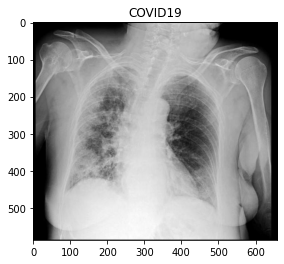

In [5]:
import cv2

label = "COVID19"

#path = os.path.join(base_path + 'train/' + label) 
path = base_path + 'train/' + label #tworzymy ścieżkę do pliku ze zdjęciami

for img in os.listdir(path): #gdy jesteśmy już w pliku ze zdjęciami, iterujemy po jego zawartości
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # zaczytanie zdjęcia w grayscale
        plt.imshow(img_array, cmap = 'gray')
        plt.title(label)
        plt.show()
        break

In [6]:
from keras.applications import EfficientNetB1

base_model = tf.keras.applications.EfficientNetB1(
    include_top=False,
    weights="imagenet",   # imagenet <- pretrained; random <- random initialization
    input_tensor=Input(shape=(image_size+(3,))),
    input_shape=None,
    pooling=None,
    #classes=1000,   # ile wyjsc, tylko jesli include_top = true
    classifier_activation="softmax",
    #**kwargs
)

27018416/27018416 [==============================] - 0s 0us/step


In [7]:
#creating head
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.35)(x)
prediction=Dense(4, activation='softmax')(x)

base_model.trainable = False

final_model = Model(inputs=base_model.input, outputs = prediction)

final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']      

In [8]:
 final_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ["accuracy"])

In [9]:
definied_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=1,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [10]:
train_steps = train_data.samples//batch_size
val_steps = val_data.samples//batch_size
test_steps = test_data.samples//batch_size

In [12]:
 hist = final_model.fit(
    train_data,
    #steps_per_epoch=train_steps,
    steps_per_epoch=32,
    epochs = 100,
    shuffle = False,
    #validation_split = 0.2,

    validation_data=val_data,
    validation_steps=val_steps,
    callbacks=[definied_callback]
)

Epoch 1/100
32/32 [==============================] - 509s 16s/step - loss: 0.4725 - accuracy: 0.5967 - val_loss: 0.7732 - val_accuracy: 0.2578
Epoch 2/100
32/32 [==============================] - 370s 11s/step - loss: 0.4583 - accuracy: 0.6221 - val_loss: 0.6921 - val_accuracy: 0.2734
Epoch 3/100
32/32 [==============================] - 332s 10s/step - loss: 0.4579 - accuracy: 0.6064 - val_loss: 0.6615 - val_accuracy: 0.2578
Epoch 4/100
32/32 [==============================] - 273s 8s/step - loss: 0.4611 - accuracy: 0.6045 - val_loss: 0.7218 - val_accuracy: 0.2969


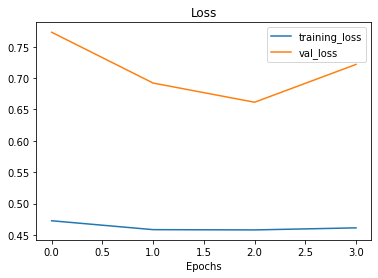

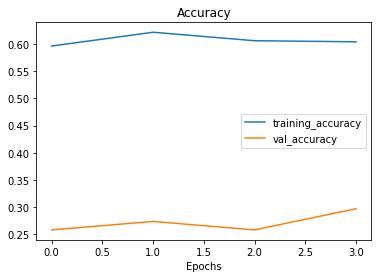

In [13]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

epochs = range(len(hist.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
 final_model.evaluate(test_data, steps=test_steps)

 3/20 [===>..........................] - ETA: 3:37 - loss: 0.4456 - accuracy: 0.5729

KeyboardInterrupt: ignored